In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('cleaned_diabetes.csv')

In [2]:
# Step 1: Identify binary and continuous columns
binary_cols = [col for col in df.columns if sorted(df[col].dropna().unique()) == [0, 1]]
continuous_cols = [col for col in df.columns if col not in binary_cols and col != 'Diabetes_012']
print(continuous_cols)
# Step 2: Calculate Q1, Q2, Q3, IQR only for continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q2 = df[continuous_cols].quantile(0.50)  # Median
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

# Step 3: Remove outliers for continuous columns only
# (Binary columns are untouched)
filter_condition = ~((df[continuous_cols] < (Q1 - IQR)) | (df[continuous_cols] > (Q3 + IQR))).any(axis=1)
df_clean = df[filter_condition]

print("\nOriginal shape:", df.shape)
print("Cleaned shape:", df_clean.shape)


['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Original shape: (164444, 14)
Cleaned shape: (103668, 14)


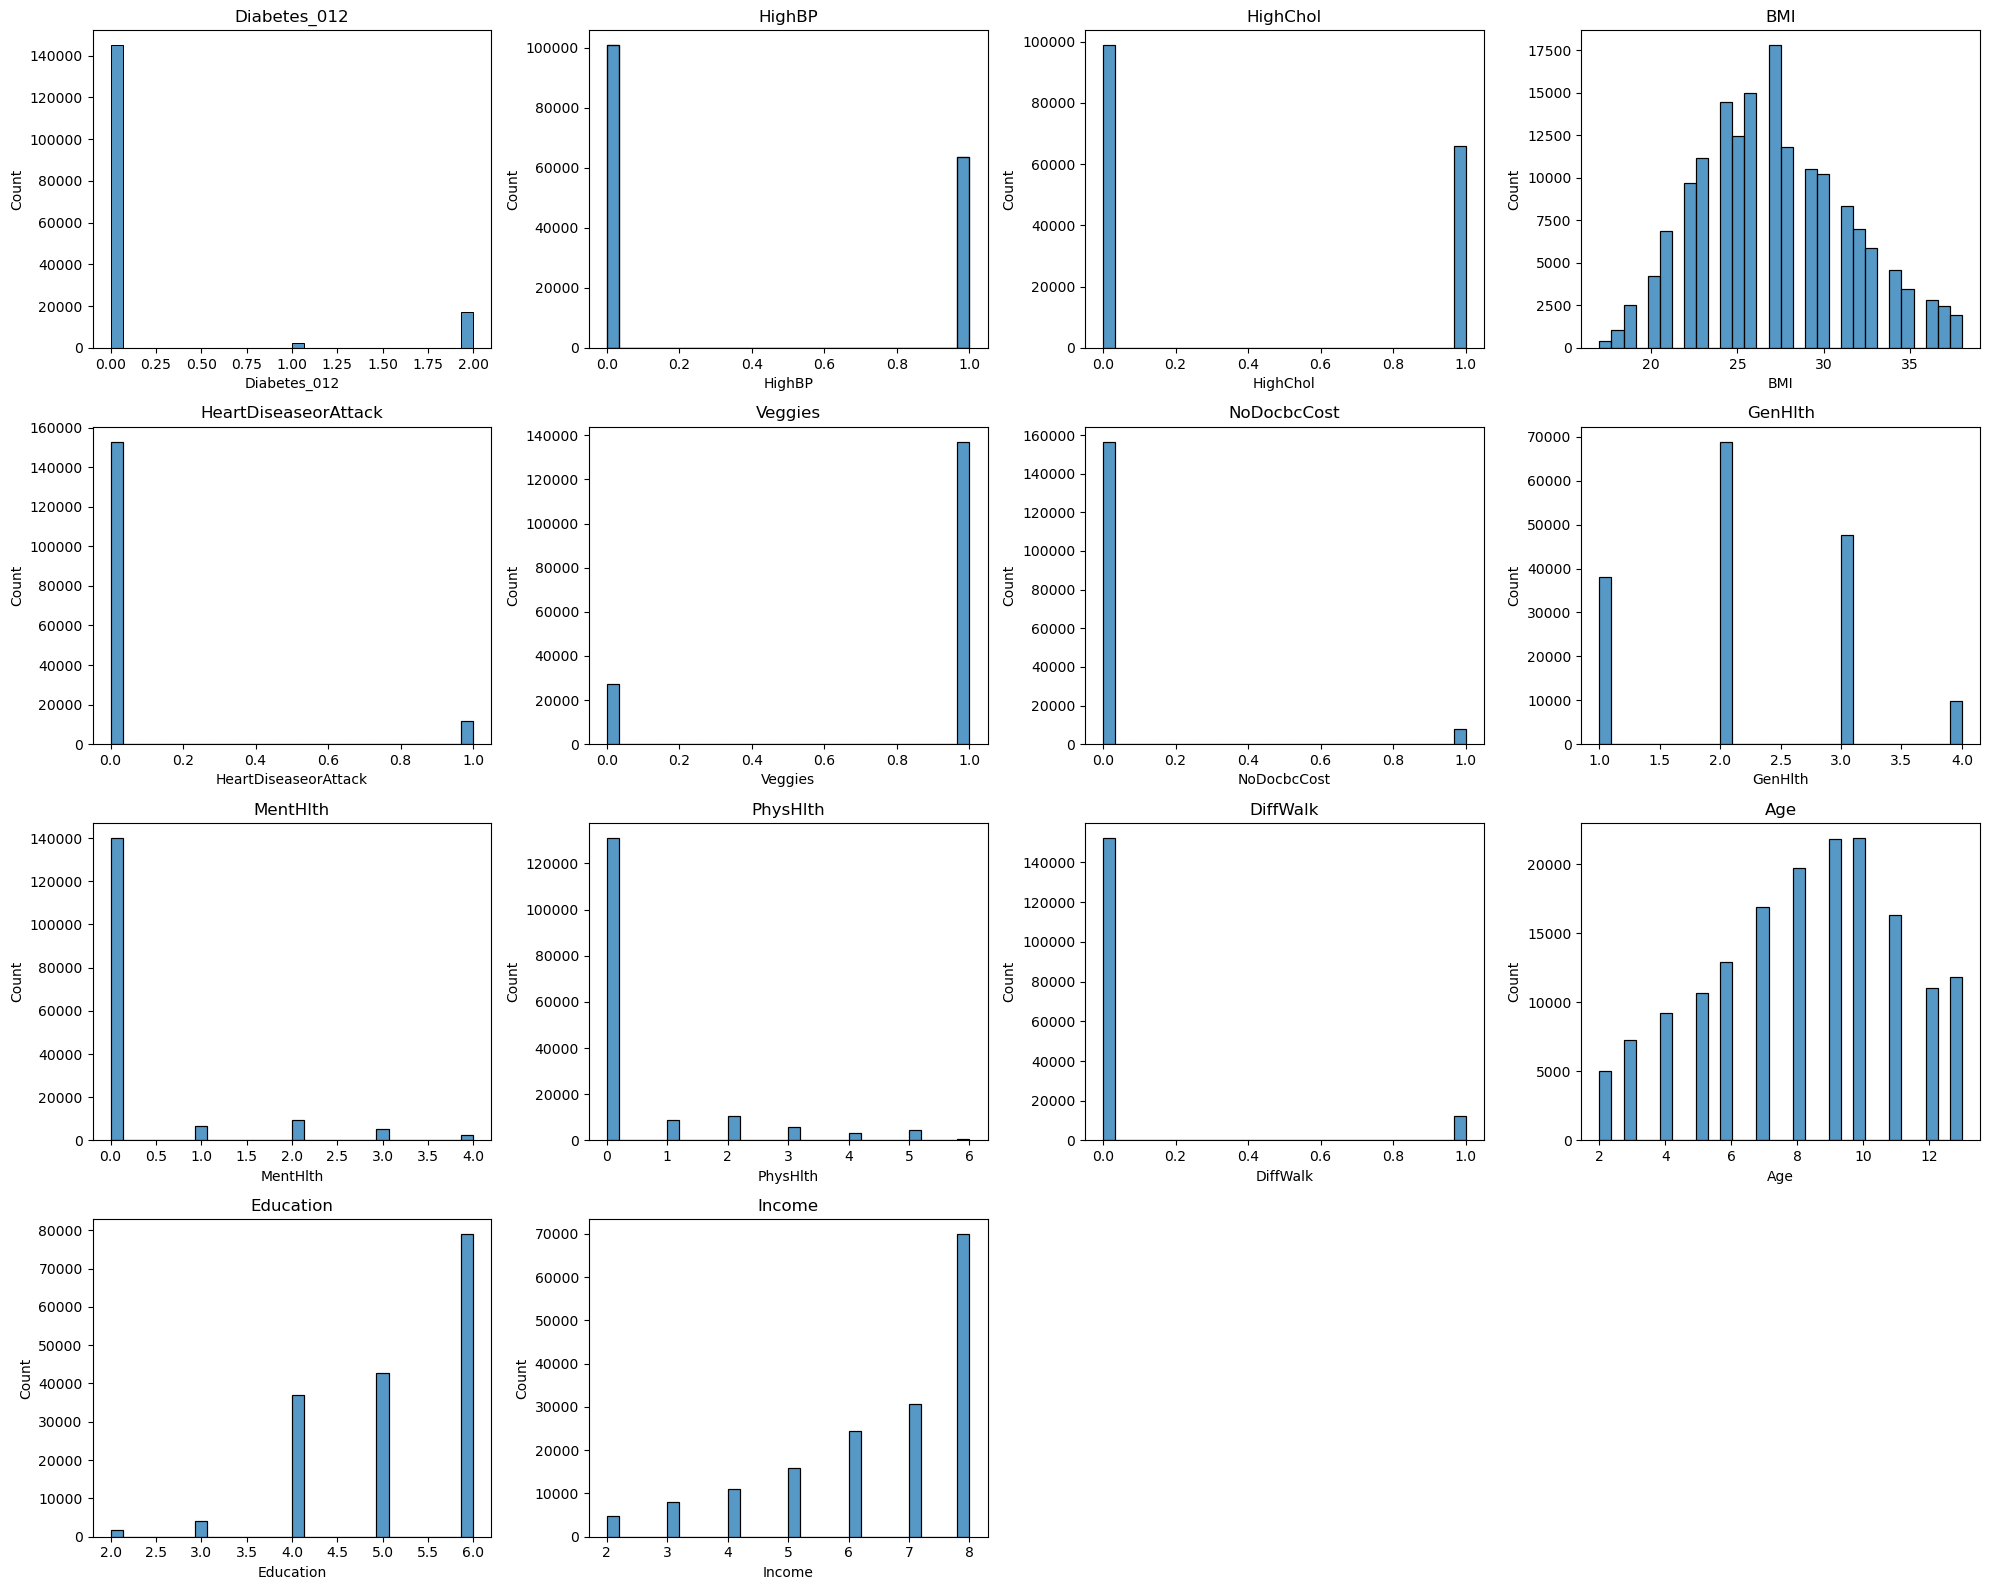

In [3]:
n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    
    # plt.subplot(n_rows, n_cols, i + 1)
    # sns.histplot(df_clean[col], bins=30, kde=False)
    # plt.title(f"{col} before/after clean")
    
    plt.tight_layout()

plt.show()


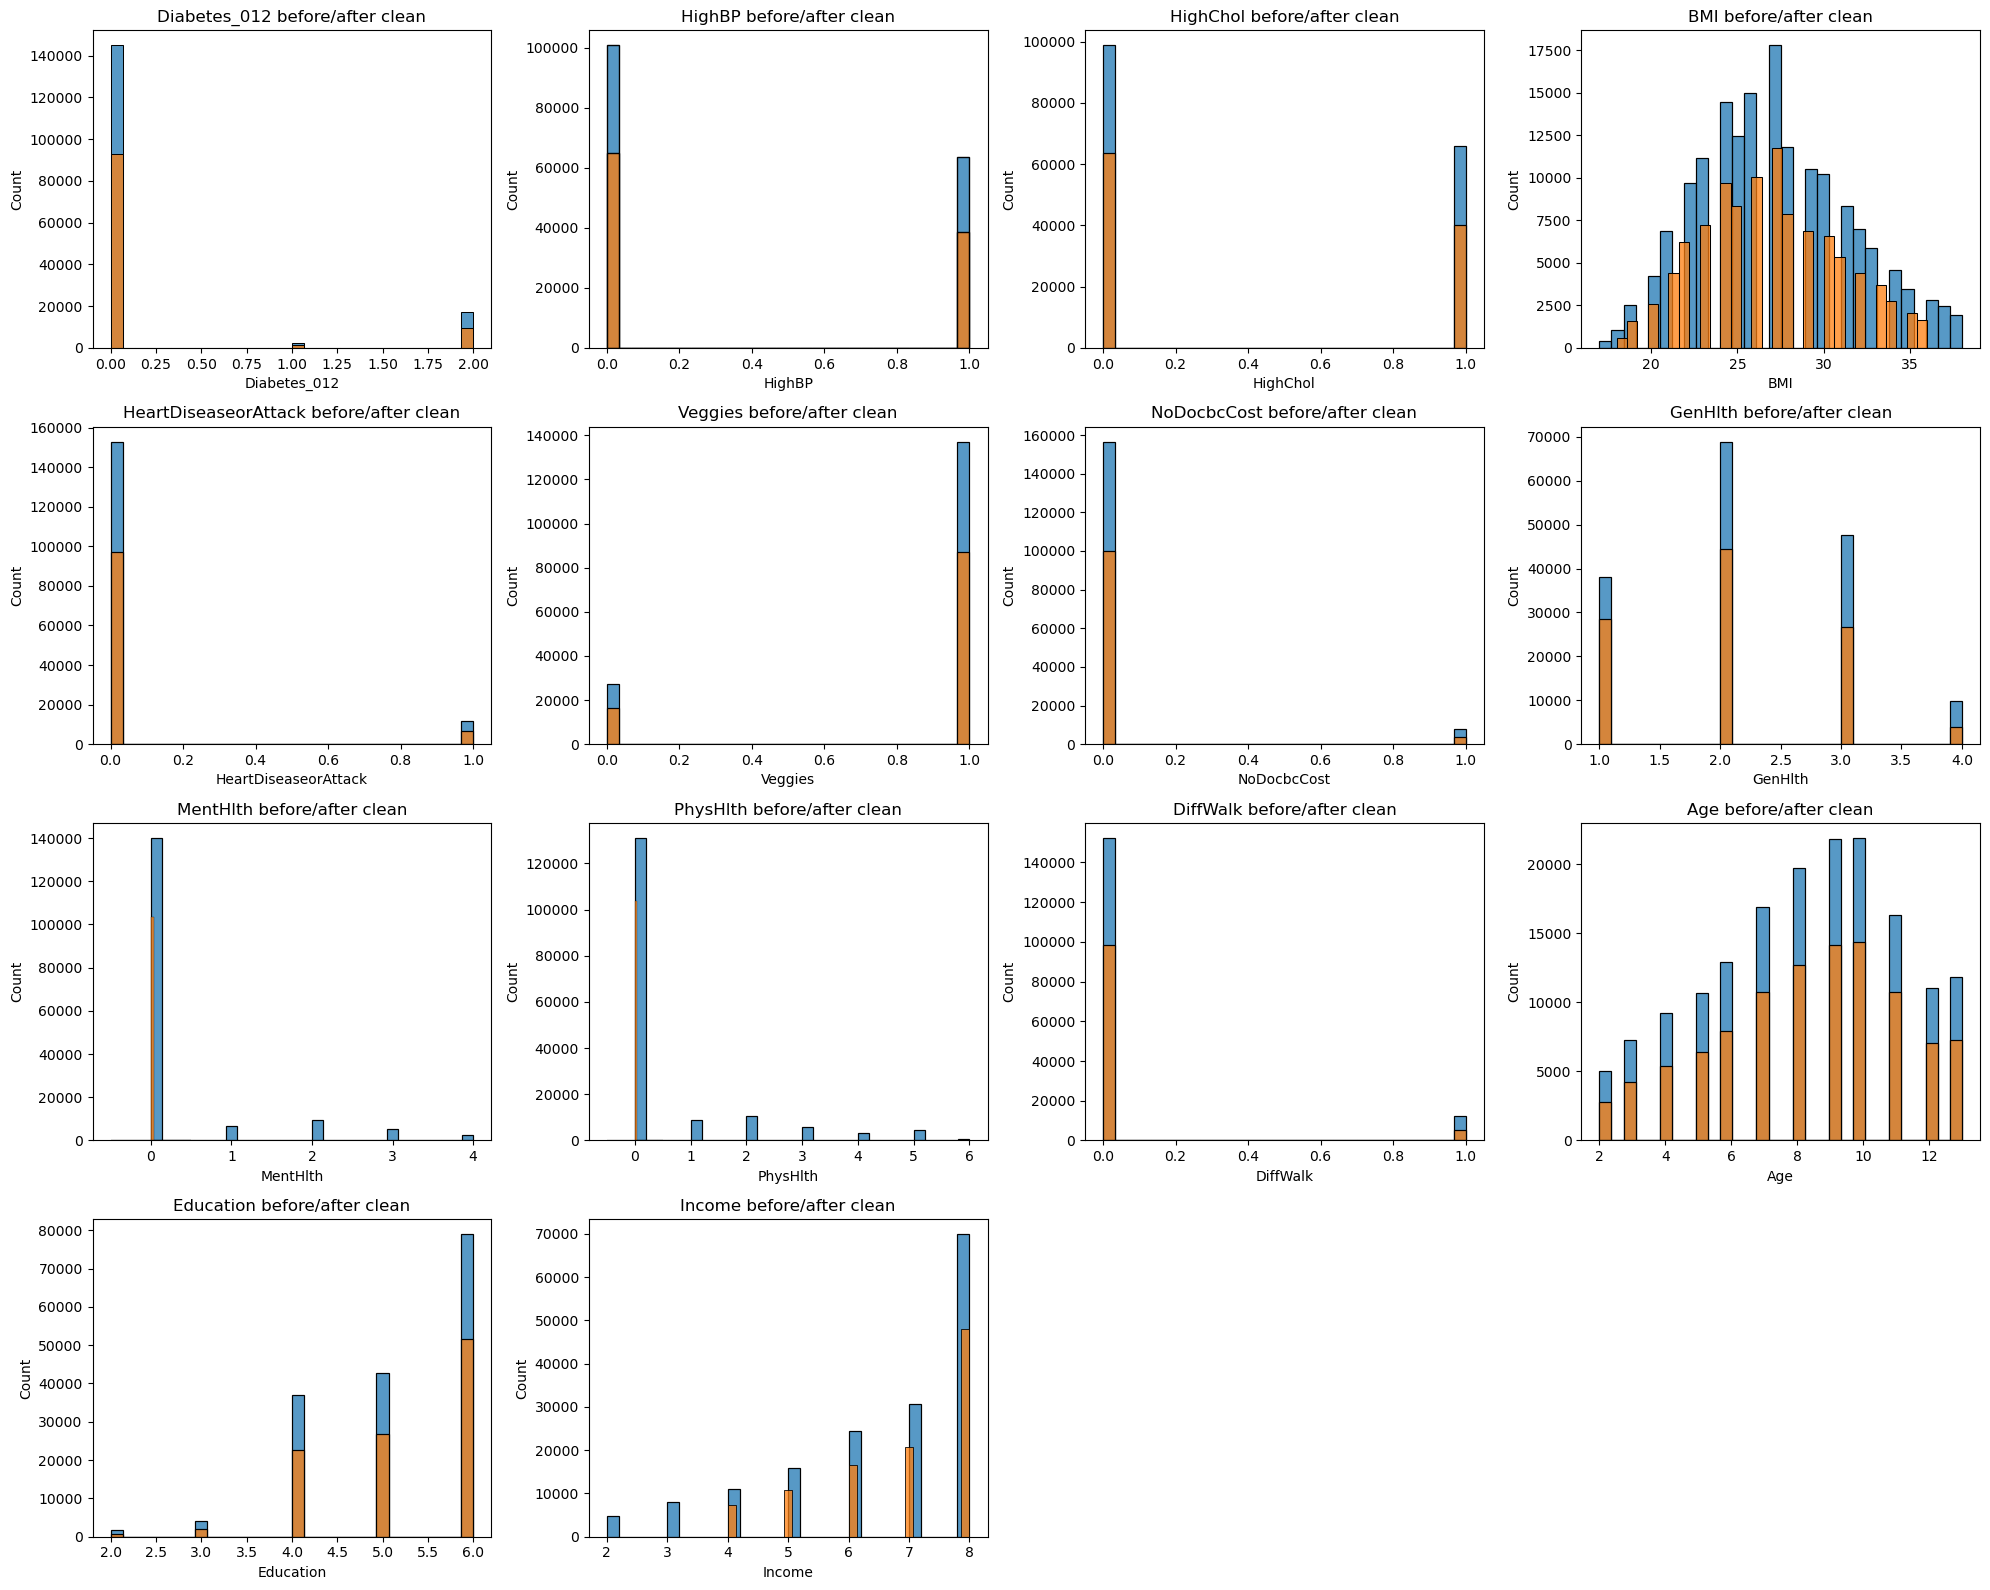

In [4]:
n_cols = 4
n_rows = (len(df.columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df[col], bins=30, kde=False)
    plt.title(col)
    
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(df_clean[col], bins=30, kde=False)
    plt.title(f"{col} before/after clean")
    
    plt.tight_layout()

plt.show()


In [5]:
# proportions of 0:1:2 diabetes
import numpy as np
y = list(df["Diabetes_012"])
length = len(y)
print(y.count(0)/length)
print(y.count(1)/length)
print(y.count(2)/length)


# pre data cleaned model simple benchmark classification

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.metrics import accuracy_score
y = list(df["Diabetes_012"])
y = list(map(lambda X: 1 if X == 2 or X == 1 else X, y))
# print(y)
X = df.to_numpy()
X = np.delete(X, 0,1)
print(X)

min_max = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

X_train = min_max.fit_transform(X_train)
X_test = min_max.transform(X_test)
print("0:1 proportions in the test dataset")
print(y_test.count(0)/len(y_test))
print(y_test.count(1)/len(y_test))

logistic = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = logistic.predict(X_test)

print(f"Logistic Regression accuracy: {accuracy_score(y_test, y_pred)}")
perceptron = Perceptron(random_state=0).fit(X_train, y_train)
y_pred = perceptron.predict(X_test)

print(f"Perceptron learning accuracy: {accuracy_score(y_test, y_pred)}")

# hypothesis: since the accuracy is almost the same as the 0 proportion, the model must be predicting 0s almost always as a cheating mechanism to
# have high accuracy.

# check if most of the correct predictions are for class 0.

num_correct_1 = 0
num_correct_0 = 0
for i in range(len(y_test)):
    
    if (y_test[i] == 1 and y_pred[i] ==1  ):
        num_correct_1+=1

    if (y_test[i] == 0 and y_pred[i] ==0  ):
        num_correct_0+=1

print(num_correct_1/y_test.count(1))
print(num_correct_0/y_test.count(0))



0.8807496777018317
0.014941256597990806
0.10430906570017756
[[ 1  0 27 ... 11  3  6]
 [ 1  1 24 ... 11  5  4]
 [ 1  1 25 ... 10  6  8]
 ...
 [ 1  1 18 ... 11  2  4]
 [ 0  0 28 ...  2  5  2]
 [ 1  1 25 ...  9  6  2]]
0:1 proportions in the test dataset
0.8817591398895672
0.11824086011043274
Logistic Regression accuracy: 0.881832113059765
Perceptron learning accuracy: 0.8815158959889081
0.006583007611602551
0.9988413793103448


# Models

In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
import random
class FCN(nn.Module):
    layers: nn.Sequential
    def __init__(self) :
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(13, 50),
            nn.ReLU(),
            nn.Linear(50, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
            nn.ReLU(),
            nn.Linear(10, 25),
            nn.ReLU(),
            nn.Linear(25, 10),
            nn.ReLU(),
            nn.Linear(10, 2),
        )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layers(x)

class CSV_Data(Dataset):
    def __init__(self, f):
        self.dat = pd.read_csv(f)
        self.y = self.dat.iloc[:, 0].to_numpy()
        self.X = self.dat.iloc[:, 1:].to_numpy()
    def __len__(self):
        return len(self.dat)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
        
def tester(model, testloader):
    correct, total = 0, 0
    with torch.no_grad():
        for i, (features, label) in enumerate(testloader):
            features = features.type(torch.float32)
            output = model(features)
            pred = torch.argmax(output, 1)
            if(pred == min(1, label)):
                correct+=1
            total+=1
    print(f"Accuracy: {(correct*100)/total} ")  

data = CSV_Data('cleaned_diabetes.csv')
# print(len(data))
train_set, test_set = torch.utils.data.random_split(data, [int(0.75*(len(data))), len(data)- int(0.75*len(data))])
trainloader = DataLoader(train_set, batch_size = 1, shuffle = True)
testloader = DataLoader(test_set, batch_size = 1, shuffle = False)
 
model = FCN()
weights = [20.0, 1.0]
class_weights = torch.FloatTensor(weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
tester(model, testloader)   
for epoch in range(5):
    print(f"Epoch {epoch+1}")
    for i, (features, label) in enumerate(trainloader):
        k =random.uniform(0.0, 1.0)
        if((k > 0.85  and label==0) or label!=0):
            # print(label)
            features = features.type(torch.float32)
            l = [min(1, label)]
            g = torch.Tensor(l)  
            
            #print(g.shape)
            optimizer.zero_grad()
            logits = model.forward(features)
            #print(logits.shape)
            loss = criterion(logits, g.long())
            loss.backward()
            optimizer.step()
    tester(model, testloader)

Accuracy: 88.0032108194887 
Epoch 1
Accuracy: 64.1288219697891 
Epoch 2
Accuracy: 70.04208119481405 
Epoch 3
Accuracy: 67.12315438690375 
Epoch 4
Accuracy: 74.55912043005522 
Epoch 5
Accuracy: 74.24047092019168 


In [100]:
def tester_1(model, testloader):
    correct, total = 0, 0
    false_positive = 0
    negatives, positives = 0, 0
    with torch.no_grad():
        for i, (features, label) in enumerate(testloader):
            features = features.type(torch.float32)
            output = model(features)
            pred = torch.argmax(output, 1)
            if(pred == label):
                correct+=1
                
            # if(pred!=0):
                # print(f" correct positive {pred}: {label}")
            total+=1
            if(label != 0):
                negatives+=1
                
            if(label != 0):
                positives+=1
            if(pred != 0 and label == 0):
                false_positive+=1
    print(correct)
    print(total)
    print(false_positive)
    print(f"false positive: {false_positive/positives}")
    print(f"Accuracy: {(correct*100)/total} ") 
print(len(testloader))
tester_1(model, testloader)

41111
27447
41111
9120
false positive: 1.851024964481429
Accuracy: 66.76315341392815 


In [101]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = []
y_true = []
for i, (features, label) in enumerate(testloader):
    features = features.type(torch.float32)
    output = model(features)
    pred = torch.argmax(output, 1)
    y_pred.append(pred[0].item())
    y_true.append(min(1, label[0].item()))

    
    

In [102]:
print(y_true.count(0))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

36184
[[27064  9120]
 [ 1470  3457]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84     36184
           1       0.27      0.70      0.39      4927

    accuracy                           0.74     41111
   macro avg       0.61      0.72      0.62     41111
weighted avg       0.87      0.74      0.78     41111



In [103]:
tester(model, trainloader)

Accuracy: 74.37911994356742 


In [104]:
from sklearn.metrics import confusion_matrix,classification_report
y_pred = []
y_true = []
for i, (features, label) in enumerate(trainloader):
    features = features.type(torch.float32)
    output = model(features)
    pred = torch.argmax(output, 1)
    y_pred.append(pred[0].item())
    y_true.append(min(1, label[0].item()))

    

In [105]:
print(y_true.count(0))
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred))

108650
[[81252 27398]
 [ 4201 10482]]
              precision    recall  f1-score   support

           0       0.95      0.75      0.84    108650
           1       0.28      0.71      0.40     14683

    accuracy                           0.74    123333
   macro avg       0.61      0.73      0.62    123333
weighted avg       0.87      0.74      0.79    123333



In [107]:
torch.save(model.state_dict(), "model.pt")